In [1]:
from environment import *

In [2]:
def run_sim(n_days, X):
    gamma = 1/25
    beta = 3
    decay = 5
    eps = 1/7
    n_iters = 200
    country_to_disable = np.array(X, dtype=np.bool_)
    mapping = airport_country.reset_index()
    mapping.columns = ['IATA', 'country_IATA']
    to_disable = mapping['country_IATA'].isin(list(countries[country_to_disable])).values
    
    max_peak_infections = 2885487730.5877514
    max_total_infections = 7138688697.766091

    env = EpidemicEnvironment(vals(adj_matrix), 
                              vals(populations), 
                              ATL, 
                              get_community(ATL), 
                              infected_idx = WUH, 
                              alphas_plus = vals(alphas),
                              lmbda = 10, 
                              mu = 0.2, 
                              centrality = centralities.values, 
                              gamma = gamma, 
                              beta = beta, 
                              epsilon = eps, 
                              beta_reduced = beta,
                              decay = decay)

    env.reset()

    for i in range(n_days):
        env.step(0)

    env.set_disabled_airports(to_disable)

    for i in range(n_iters - n_days):
        env.step(0)

    res = pd.DataFrame(env.stateHistory.sum(axis=2))
    res.columns = ['S', 'E', 'I', 'R']
    res['t'] = pd.Series(range(1,n_iters+1))

    return res

In [3]:
# EXTRACT STATEHISTORY FOR EACH OF THE STRATEGIES
no_measures = {}
genetic_measures = {}
close_all_measures = {}

X_no_measures = pd.read_csv('./outputs/genetic_countries_comparison_open.csv')
X_genetic_measures = pd.read_csv('./outputs/genetic_countries_to_close.csv')
X_close_all_measures = pd.read_csv('./outputs/genetic_countries_comparison_close.csv')

for day in range(5):
    genetic_measures[day+1] = run_sim(day+1, X_genetic_measures[[str(day+1)]].values.squeeze())
    no_measures[day+1] = run_sim(day+1, X_no_measures[[str(day+1)]].values.squeeze())
    genetic_measures[day+1] = run_sim(day+1, X_genetic_measures[[str(day+1)]].values.squeeze())
    close_all_measures[day+1] = run_sim(day+1, X_close_all_measures[[str(day+1)]].values.squeeze())

country_map = pd.read_csv('./outputs/airport_country_mapping.csv')

In [4]:
# EXTRACT STATEHISTORY FOR CENTRALITY-BASED STRATEGY ()
pr_measures = {}
for day in range(5):
    days_max = 200
    fraction_to_disable = 0.01
    n_days = 3
    n_iters = days_max
    gamma = 1/25
    beta = 3
    eps = 1/7
    decay = 5

    env = EpidemicEnvironment(vals(adj_matrix), 
                              vals(populations), 
                              ATL, 
                              get_community(ATL), 
                              infected_idx = WUH, 
                              alphas_plus = vals(alphas), 
                              lmbda = 10, 
                              mu = 0.2, 
                              centrality = centralities.values, 
                              gamma = gamma, 
                              beta = beta, 
                              epsilon = eps, 
                              beta_reduced = beta,
                              decay = decay)

    env.reset()

    for i in range(n_days):
        env.step(0)

    to_disable = close_airport_pct(1 - fraction_to_disable, centralities)    
    env.set_disabled_airports(to_disable)

    for i in range(n_iters - n_days):
        env.step(0)

    res = pd.DataFrame(env.stateHistory.sum(axis=2))
    res.columns = ['S', 'E', 'I', 'R']
    res['t'] = pd.Series(range(1,n_iters+1))
    
    pr_measures[day+1] = res

In [5]:
# COMPARE GA WITH UNMITIGATED SCENARIO
max_peak_infections = 2885487730.5877514
max_total_infections = 7138688697.766091
max_peak_infections_fraction = max_peak_infections / populations.sum().values[0]
max_total_infections_fraction = max_total_infections / populations.sum().values[0]

table_ga_infections = 'max(I) & '
table_ga_recoveries = 'max(R) & '
for day in range(5):
    reduced_pct_infections = (1 - (genetic_measures[day+1]['I'].max() / max_peak_infections)) * 100
    table_ga_infections += '{0: >7}'.format(str(round(reduced_pct_infections,1))) + ' & '
    reduced_pct_recoveries = (1 - (genetic_measures[day+1]['R'].max() / max_total_infections)) * 100
    table_ga_recoveries += '{0: >7}'.format(str(round(reduced_pct_recoveries,1))) + ' & '
table_ga_infections += '{0: >7}'.format(str(round(100*max_peak_infections_fraction,1))) + ' \\\\'
table_ga_recoveries += '{0: >7}'.format(str(round(100*max_total_infections_fraction,1))) + ' \\\\'

print(table_ga_infections)
print(table_ga_recoveries)

max(I) &    79.8 &    36.9 &    29.0 &    29.8 &    31.1 &    37.0 \\
max(R) &    86.8 &    34.1 &     8.9 &     7.2 &     5.6 &    91.5 \\


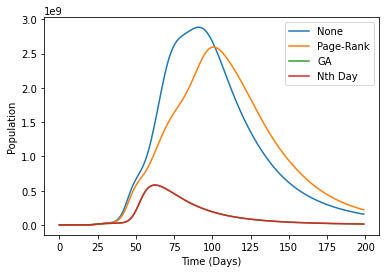

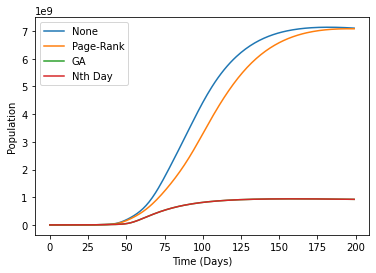

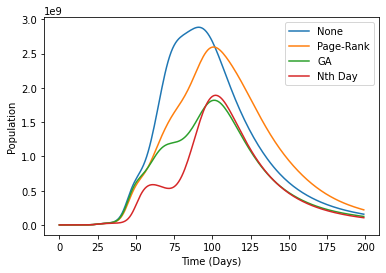

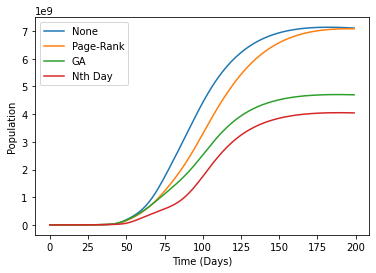

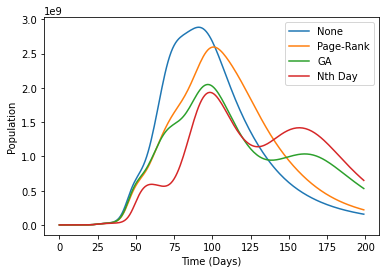

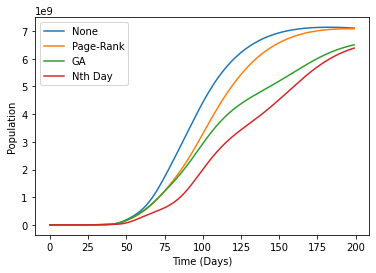

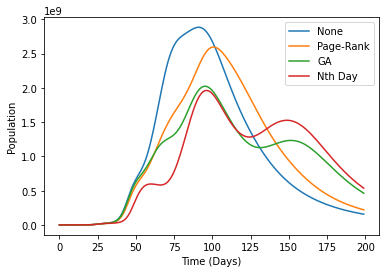

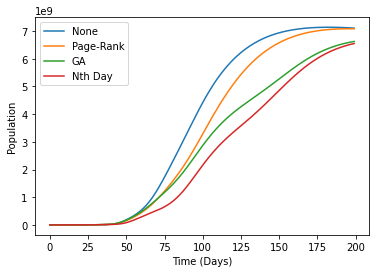

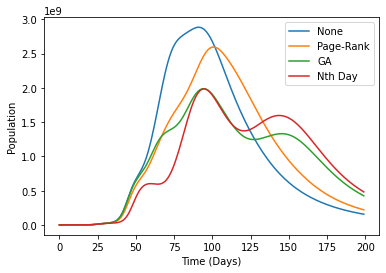

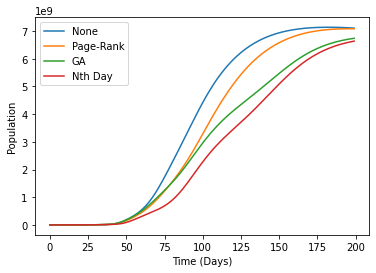

In [7]:
# SHOW INFECTED AND RECOVERED FOR EACH STRATEGY
for day in range(5):
    df_inf = pd.DataFrame({'None':no_measures[day+1]['I'], 
                           'Page-Rank':pr_measures[day+1]['I'], 
                           'GA':genetic_measures[day+1]['I'], 
                           'Nth Day':close_all_measures[day+1]['I']})
    df_inf.plot()
    plt.xlabel('Time (Days)')
    plt.ylabel('Population')
    plt.savefig('./outputs/plots/ga_compare_infected_' + str(day+1) + '.pdf')

    df_rec = pd.DataFrame({'None':no_measures[day+1]['R'], 
                           'Page-Rank':pr_measures[day+1]['R'], 
                           'GA':genetic_measures[day+1]['R'], 
                           'Nth Day':close_all_measures[day+1]['R']})
    df_rec.plot()
    plt.xlabel('Time (Days)')
    plt.ylabel('Population')
    plt.savefig('./outputs/plots/ga_compare_recovered_' + str(day+1) + '.pdf')

In [11]:
# get number of closed countries
print(X_genetic_measures.shape)
print(X_genetic_measures.sum(axis=0))

(220, 6)
Unnamed: 0    CANARGRUSTLSUSAESPIDNCHNGBRMNEDEUCHEGRLNPLMEXS...
1                                                            83
2                                                           113
3                                                            88
4                                                           109
5                                                           103
dtype: object
